In [1]:
if "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random


import matplotlib.pyplot as plt
import seaborn as sns
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

gc.collect()

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

31343

In [3]:
# PCA_ = PCA(n_components=60).fit(X_norm)
# X_PCA = PCA_.transform(X_norm)
# # X_TSNE = TSNE(n_components=60, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
# reducer = umap.UMAP(min_dist=0.9, n_components=60)
# X_UMAP = reducer.fit_transform(X_norm)
# X_batch = np.reshape(X_UMAP, (X_UMAP.shape[0]//5,5,X_UMAP.shape[1]))
# # X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

In [23]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

# AE Model

In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

models = [1,3,5,7,10,20,30,40,50]

accuracies = []
f1_scores = []
recalls = []
for  i, mod_id in enumerate(models):

    X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/{mod_id}/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
    X_ae = np.asarray(X_ae)
    y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/{mod_id}/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))
    
    y = np.asarray(y_path)
    y_2 = y[:,0]
    for i in range(len(y_2)):
        y_2[i] = y_2[i][0:-2] 
    y_2 = list(y_2)
    y_3 = np.repeat(y_2, 5)
    labels_ae = []
    for i in range(len(y_2)):
        labels_ae.append(audios.loc[y_2[i], "cover"])
        
    X_ae = np.reshape(X_ae, [X_ae.shape[0]//5, 5, X_ae.shape[1]])
        
    X_train, X_test, y_train, y_test = train_test_split(X_ae, labels_ae, test_size=0.2,random_state=0)
    
    X_train = np.reshape(X_train, [X_train.shape[0]*5, X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5, X_test.shape[2]])
    
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    
    
    
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)

    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)
    
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    recalls.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies.npy", accuracies)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores.npy", f1_scores)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls.npy", recalls)

# X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
# X_ae = np.asarray(X_ae)
# y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))

# scaler = StandardScaler().fit(X_ae)
# X_scaled = scaler.transform(X_ae)

# Normalizer_ = Normalizer().fit(X_ae)
# X_norm = Normalizer_.transform(X_ae)


NameError: name 'torch' is not defined

## 5 segments flattened 

In [21]:
X_ae = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
X_ae = np.asarray(X_ae)
y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/log_standarization_epochs_10/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))

y = np.asarray(y_path)
y_2 = y[:,0]
for i in range(len(y_2)):
    y_2[i] = y_2[i][0:-2] 
y_2 = list(y_2)
y_3 = np.repeat(y_2, 5)
labels_ae = []
for i in range(len(y_3)):
    labels_ae.append(audios.loc[y_3[i], "cover"])

df_ae = pd.DataFrame(X_ae)
df_ae["y"] = y_3

In [8]:
audios

,index,field_number_PR,longitud_IG,latitude_IG,day_init_TI,day_end_TI,samp_rate_RE,habitat,pasture,savanna,forest,cover,Filename,name_FI,rain_FI,Filename_
Filename_,,,,,,,,,,,,,,,,
RZUA01_20220906_063000.WAV,0,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220906_063000.WAV,20220906_063000,NO,RZUA01_20220906_063000.WAV
RZUA01_20220909_023000.WAV,1,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220909_023000.WAV,20220909_023000,YES,RZUA01_20220909_023000.WAV
RZUA01_20220903_104500.WAV,2,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_104500.WAV,20220903_104500,YES,RZUA01_20220903_104500.WAV
RZUA01_20220903_110000.WAV,3,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_110000.WAV,20220903_110000,NO,RZUA01_20220903_110000.WAV
RZUA01_20220903_111500.WAV,4,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_111500.WAV,20220903_111500,NO,RZUA01_20220903_111500.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUD01M_20220911_074500.WAV,767,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_074500.WAV,20220911_074500,NO,RZUD01M_20220911_074500.WAV
RZUD01M_20220911_080000.WAV,768,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_080000.WAV,20220911_080000,NO,RZUD01M_20220911_080000.WAV
RZUD01M_20220911_081500.WAV,769,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_081500.WAV,20220911_081500,NO,RZUD01M_20220911_081500.WAV


In [5]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ae[['location', 'day', 'hour']] =df_ae['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ae['hour_stage'] =df_ae['hour'].apply(define_hour_stage)
df_ae.set_index("y", inplace=True, drop=False)
df_ae['cover'] = df_ae.index.map(audios['cover'])

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae = []
f1_scores_ae = []
recalls_ae = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae[df_ae['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:5183])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae.append(accuracy)
    f1_scores_ae.append(f1_score)
    recalls_ae.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae.npy", accuracies_ae)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae.npy", f1_scores_ae)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae.npy", recalls_ae)

## UNFLAT Mean

In [24]:
print(X_ae.shape)
X_ae_unflat = np.reshape(X_ae, [X_ae.shape[0]//5,5,X_ae.shape[1]])
print(X_ae_unflat.shape)
X_ae_unflat2 = np.reshape(X_ae_unflat, [X_ae_unflat.shape[0], X_ae_unflat.shape[1]*X_ae_unflat.shape[2]])
print(X_ae_unflat2.shape)
X_ae_unflat3 = np.reshape(X_ae_unflat2, [X_ae_unflat2.shape[0], 5, X_ae_unflat2.shape[1]//5])
print(X_ae_unflat3.shape)
X_ae_flat = np.reshape(X_ae_unflat3, [X_ae_unflat3.shape[0]*5,X_ae_unflat3.shape[2]])
print(X_ae_flat.shape)
print((X_ae_flat == X_ae).all())

(325320, 5184)
(65064, 5, 5184)
(65064, 25920)
(65064, 5, 5184)
(325320, 5184)
True


In [31]:
X_ae_unflat = np.reshape(X_ae, [X_ae.shape[0]//5,5,X_ae.shape[1]])
X_ae_unflat = X_ae_unflat.mean(axis=1)
# X_ae_unflat = np.median(X_ae_unflat, axis=1)
# X_ae_unflat = np.reshape(X_ae_unflat, [X_ae_unflat.shape[0], X_ae_unflat.shape[1]*X_ae_unflat.shape[2]])
df_ae_unflat = pd.DataFrame(X_ae_unflat)
df_ae_unflat["y"] = y_2

In [33]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ae_unflat[['location', 'day', 'hour']] =df_ae_unflat['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ae_unflat['hour_stage'] =df_ae_unflat['hour'].apply(define_hour_stage)
df_ae_unflat.set_index("y", inplace=True, drop=False)
df_ae_unflat['cover'] = df_ae_unflat.index.map(audios['cover'])
df_ae_unflat['rain_FI'] = df_ae_unflat.index.map(audios['rain_FI'])
# df_ae_unflat['habitat'] = df_ae_unflat.index.map(audios['habitat'])
df_ae_unflat = df_ae_unflat[df_ae_unflat['rain_FI'] == 'NO']
df_ae_unflat = df_ae_unflat.dropna()

In [4]:
df_ae_unflat.to_csv('df_ae_unflat.csv', index=False) 

NameError: name 'df_ae_unflat' is not defined

In [4]:
df_ae_unflat = pd.read_csv("New_df_ae_unflat.csv")
df_ae_unflat.set_index("y", inplace=True)
df_ae_unflat

## All classification covers

Accuracy: 0.7857343969967152
f1: 0.7169111508027285
recall 0.6933961958610086
[[0.11374941 0.05912717 0.02665415]
 [0.01098076 0.54443923 0.01661192]
 [0.03359925 0.06729235 0.12754575]]
[[1212  630  284]
 [ 117 5801  177]
 [ 358  717 1359]]


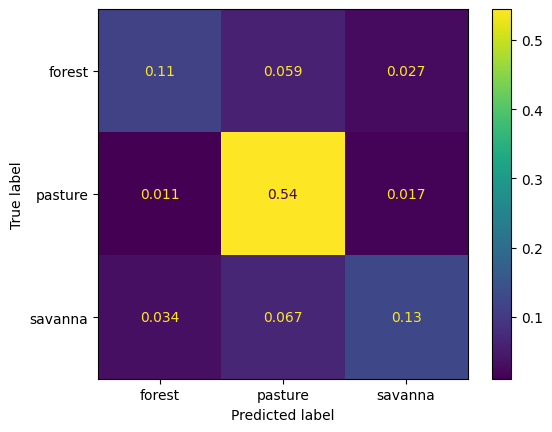

In [19]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = np.asarray(df_ae_unflat.iloc[:,0:25920])
y = np.asarray(df_ae_unflat.loc[:,"cover"])
# X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5]) # 0.805
# X = np.mean(X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
# X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
# X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
# y_train = np.repeat(y_train,5)
# y_test = np.repeat(y_test,5)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])
cm_display.plot()
plt.show()



## All classification hours

Accuracy: 0.8363397465978414
f1: 0.7593890815743308
recall 0.7476706704247329
[[0.3038198  0.01392773 0.01880807]
 [0.0605725  0.06661661 0.03489442]
 [0.02714219 0.00831534 0.46590333]]
[[16186   742  1002]
 [ 3227  3549  1859]
 [ 1446   443 24821]]


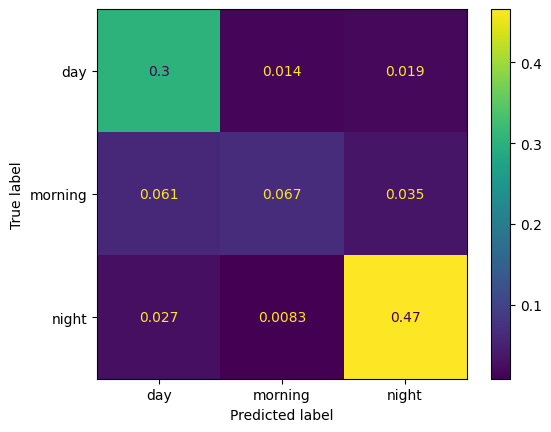

In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = np.asarray(df_ae_unflat.iloc[:,0:25920])
y = np.asarray(df_ae_unflat.loc[:,"hour_stage"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
# X = np.mean(X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
y_train = np.repeat(y_train,5)
y_test = np.repeat(y_test,5)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()


## Cover Classification

In [43]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae_unflat_covers = []
f1_scores_ae_unflat_covers = []
recalls_ae_unflat_covers = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:25920])
    y = np.asarray(df_day.loc[:,"cover"])
    X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_covers.append(accuracy)
    f1_scores_ae_unflat_covers.append(f1_score)
    recalls_ae_unflat_covers.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_covers.npy", accuracies_ae_unflat_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_covers.npy", f1_scores_ae_unflat_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_covers.npy", recalls_ae_unflat_covers)

Accuracy: 0.8662650602409638
f1: 0.7753242713678086
recall 0.7391291291291292
Accuracy: 0.8700122399020808
f1: 0.8093067613339396
recall 0.7879184806784755
Accuracy: 0.8315378610460578
f1: 0.7939973560107022
recall 0.7749281451411436
Accuracy: 0.8140013726835964
f1: 0.7689633559537318
recall 0.7501766761851812
Accuracy: 0.8051140290255702
f1: 0.7447106715418518
recall 0.7190642499254808
Accuracy: 0.777933177933178
f1: 0.7055653342938027
recall 0.6811955531255696
Accuracy: 0.8236328125
f1: 0.7746488090824893
recall 0.7607526451392587
Accuracy: 0.8442790697674418
f1: 0.803267746236632
recall 0.783950038918983
Accuracy: 0.8460854092526691
f1: 0.804181034802648
recall 0.7790410207114121
Accuracy: 0.8495867768595041
f1: 0.7850509910087359
recall 0.7521924465538924
Accuracy: 0.9260869565217391
f1: 0.8807838187666515
recall 0.8491149795830646


## Hour Stage Classification

In [44]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

df_day={}
accuracies_ae_unflat_hours = []
f1_scores_ae_unflat_hours = []
recalls_ae_unflat_hours = []
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:25920])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
    X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
    y_train = np.repeat(y_train,5)
    y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_hours.append(accuracy)
    f1_scores_ae_unflat_hours.append(f1_score)
    recalls_ae_unflat_hours.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_hours.npy", accuracies_ae_unflat_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_hours.npy", f1_scores_ae_unflat_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_hours.npy", recalls_ae_unflat_hours)

Accuracy: 0.8975903614457831
f1: 0.5757824742160399
recall 0.5853505291005291
Accuracy: 0.8859241126070991
f1: 0.7941672362724993
recall 0.7670764947876281
Accuracy: 0.8518345042935207
f1: 0.7900538503186275
recall 0.7774422476937559
Accuracy: 0.885929993136582
f1: 0.8514798588215508
recall 0.8426998142456418
Accuracy: 0.8957843814789219
f1: 0.8586258619446102
recall 0.84663987090734
Accuracy: 0.8590520590520591
f1: 0.8270166313492977
recall 0.8143420877122779
Accuracy: 0.841796875
f1: 0.6935792187778779
recall 0.6799262398818783
Accuracy: 0.8258604651162791
f1: 0.6737255831239798
recall 0.6737953997391001
Accuracy: 0.8829181494661922
f1: 0.8472106222792494
recall 0.8331473730128808
Accuracy: 0.8958677685950414
f1: 0.8765594871159181
recall 0.8715872002270469
Accuracy: 0.8669565217391304
f1: 0.841851302800927
recall 0.8379233870967742


### Autoencoders Features and Labels using independent segments

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ae, labels_ae, test_size=0.2,random_state=0)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

### Autoencoders Features and Labels using 5 segments of the audio

In [ ]:
X_batch = np.reshape(X_ae, (X_ae.shape[0]//5,5,X_ae.shape[1]))
y_batch = np.reshape(y_ae, (y_ae.shape[0]//5, 5))

In [ ]:
y_3 == y_path[:,0]

In [ ]:
len(labels_ai), y_path[0].shape

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_batch, y_path, test_size=0.2,random_state=0)

X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])

labels_train = []
for i in range(len(y_train)):
    labels_train.append(audios.loc[y_train[i], "cover"])
labels_test = []
for i in range(len(y_test)):
    labels_test.append(audios.loc[y_test[i], "cover"])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, labels_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(labels_test, y_pred_rf)
f1_score = metrics.f1_score(labels_test, y_pred_rf, average="macro")
recall = metrics.recall_score(labels_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

# Autoencoders Features and Labels using voting labels

In [ ]:
y_pred_rf2 = np.asarray(y_pred_rf)
y_pred_rf2 = np.reshape(y_pred_rf2,(y_pred_rf2.shape[0]//5,5))
y_test2 = np.asarray(labels_test)
y_test2 = np.reshape(y_test2,(y_test2.shape[0]//5,5))

def most_frequent(List):
    return max(set(List), key = List.count)

labels_test2 = []
labels_pred = []
for i in range(len(y_pred_rf2)):
    labels_pred.append(most_frequent(list(y_pred_rf2[i])))
    labels_test2.append(most_frequent(list(y_test2[i])))
accuracy_ae = metrics.accuracy_score(labels_test2, labels_pred)
f1_score_ae = metrics.f1_score(labels_test2, labels_pred, average="macro")
recall_ae = metrics.recall_score(labels_test2, labels_pred, average="macro")

print("Accuracy:", accuracy_ae)
print("f1:", f1_score_ae)
print("recall", recall_ae)